## Sentiment Analysis Pipeline (EDA Phase)
Author: Sachin Basyal

Date: December 24, 2025

Subject: Exploratory Data Analysis & Preprocessing Strategy for Sentiment Classification

### 1. Executive Summary
This report outlines the Exploratory Data Analysis (EDA) phase for a Natural Language Processing (NLP) project aimed at classifying user sentiment into Positive (1), Neutral (0), and Negative (-1) categories.

**Key Objectives:**

- Data Integrity: Ensure the dataset is free of nulls, duplicates, and noise (URLs, formatting errors) to prevent model leakage.

- Class Balance: Analyze the distribution of target variables to anticipate potential bias in model training.

- Linguistic patterns: Utilize NLTK to uncover frequent lexical patterns (n-grams) that drive sentiment.

**Dataset Overview:**
- Source: Publicly available social media comments (Twitter/Reddit) via [Kaggle].

- Initial Size: ~37,000 observations.

- Final Processed Size: ~36,700 observations (after cleaning).

- Class Distribution: Slight imbalance favoring Positive sentiments (43%).

### 2. Phase I: Data Acquisition & Preprocessing
*Goal: Establish a clean, standardized dataset to ensure downstream model reliability.*

#### 2.1 Environment Setup
We utilize standard data science libraries for manipulation and visualization.

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Configuration for cleaner output presentation
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

#### 2.2 Dataset Source & Description
The data for this analysis is sourced from the Twitter and Reddit Sentimental Analysis Dataset, available on Kaggle. It consists of user-generated content labeled for sentiment analysis tasks.

- **Repository:** Kaggle: Twitter and Reddit Sentimental Analysis Dataset - [[Link]](https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset)

- **Data Structure:** The dataset contains two primary columns:

  - clean_comment (String): The raw text of the user's comment or tweet.

  - category (Integer): The sentiment label manually annotated or pre-classified.

- **Target Mapping:**

  - +1: Positive (Expressing satisfaction, happiness, or agreement)

  - 0: Neutral (Factual statements or non-opinionated text)

  - -1: Negative (Expressing dissatisfaction, anger, or disagreement)

#### 2.3 Data Loading & Initial Inspection
The raw dataset contains clean_comment (text features) and category (target).

In [74]:
df=pd.read_csv("Dataset/Reddit_Data.csv")
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [75]:
df.shape

(37249, 2)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [77]:
df.sample()['clean_comment'].values

array(['bjp has done things that damage the independence institutions question congress comes power will gress immediate basis seek reverse these damages and more importantly pass legislation ensure that the independence won get eroded ever again '],
      dtype=object)

In [78]:
df['category'].unique()

array([ 1, -1,  0])

#### 2.4 Data Cleaning Pipeline
Rationale: Real-world social media text is notoriously noisy. We implement a rigorous cleaning pipeline to remove artifacts that do not carry semantic meaning for sentiment.

Handling Missing Values: Dropping nulls prevents execution errors during vectorization.

Duplicate Removal: Duplicates can artificially inflate model accuracy scores; we remove them to ensure validity.

Text Standardization: Lowercasing reduces vocabulary size (dimensionality reduction).

Noise Removal: Regex is used to strip URLs and newline characters.

In [79]:
import re
from collections import Counter

# 1. Null Value Treatment
print(f"Missing values before cleaning:\n{df.isna().sum()}")
df.dropna(inplace=True)

# 2. Duplicate Removal
df.drop_duplicates(inplace=True)

# 3. Artifact Removal (Whitespace & URLs)
# Note: We do this BEFORE lowercasing to ensure regex captures patterns correctly
df['clean_comment'] = df['clean_comment'].str.strip()

# Regex to identify and remove URLs
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
df = df[~df['clean_comment'].str.contains(url_pattern)].copy()

# 4. Remove Non-English Characters
# We keep: Alphanumeric, spaces, basic punctuation (.,!?), and apostrophes (for contractions)
# We remove: Emojis, foreign scripts, and special symbols
def clean_non_english(text):
    # Pattern explanation: ^ means "not in this list". 
    # We replace anything NOT in A-Z, a-z, 0-9, space, or !?.,' with empty string
    return re.sub(r'[^A-Za-z0-9\s!?.,\']', '', str(text))

df['clean_comment'] = df['clean_comment'].apply(clean_non_english)

# 5. Text Normalization (Lowercasing)
df['clean_comment'] = df['clean_comment'].str.lower()

# Remove new line characters
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ')

print(f"Final Cleaned Dataset Shape: {df.shape}")

# --- VALIDATION STEP ---
# Verify that weird characters are gone by checking character frequency
all_text = ' '.join(df['clean_comment'])
char_frequency = Counter(all_text)
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

# Display the tail to check the least frequent characters (this is where "junk" usually hides)
print("\nLeast frequent characters verification:")
print(char_frequency_df.tail(10))

Missing values before cleaning:
clean_comment    100
category           0
dtype: int64
Final Cleaned Dataset Shape: (36799, 2)

Least frequent characters verification:
   character  frequency
27         5       1631
35         3       1617
29         4       1573
28         6       1403
36         7       1291
33         8       1199
38                   76
37        \t         11
40                    3
39                    1


### 3. Statistical Analysis & Feature Engineering
*Goal: Understand the statistical properties of the data.*

#### 3.1 Target Variable Distribution
Insight: We observe a Class Imbalance.

Positive (1): ~43%

Neutral (0): ~35%

Negative (-1): ~22%

Strategic Note: While not severe, this imbalance suggests we should monitor Recall/F1-Score for the "Negative" class closely during modeling, as the model has fewer examples to learn from.

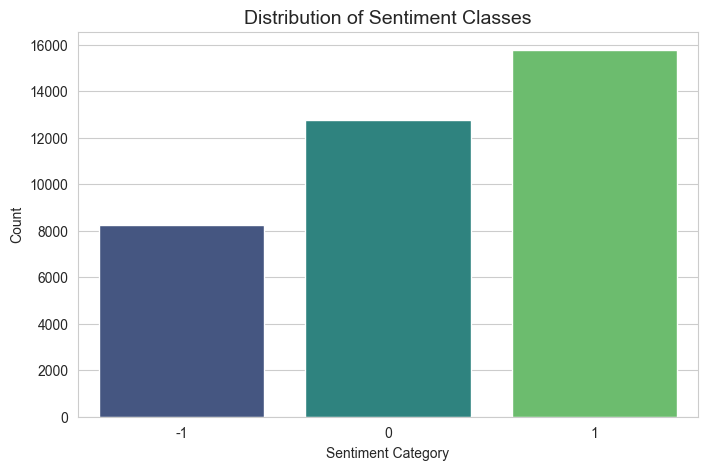

category
 1    42.86
 0    34.72
-1    22.42
Name: proportion, dtype: float64


In [80]:
# Visualization of Sentiment Distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='category', palette='viridis')
plt.title('Distribution of Sentiment Classes', fontsize=14)
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# Precise Proportions
print(df['category'].value_counts(normalize=True).mul(100).round(2))

### 3.2 Feature Engineering: Text Length Analysis
We hypothesize that emotional intensity might correlate with comment length. We generate a new feature word_count.

In [81]:
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))
df.sample(5)

,clean_comment,category,word_count
27329,can anyone explain standard tax deduction and ...,0,38
1319,has ship actually picked any the floating obje...,0,12
14433,sad reax onli,-1,3
19430,total comments this moment and one even talks ...,1,51
2699,dunno works not but have admit the pills are y...,0,10


In [82]:
df['word_count'].describe()

count    36799.000000
mean        29.521753
std         56.477328
min          0.000000
25%          6.000000
50%         13.000000
75%         30.000000
max       1307.000000
Name: word_count, dtype: float64

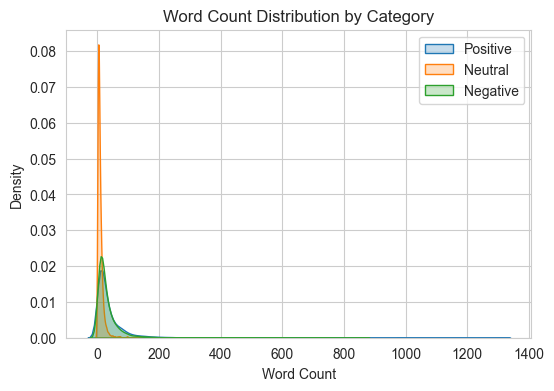

In [83]:
plt.figure(figsize=(6,4))
sns.kdeplot(df[df['category']==1]['word_count'], label='Positive', fill=True)
sns.kdeplot(df[df['category']==0]['word_count'], label='Neutral', fill=True)
sns.kdeplot(df[df['category']==-1]['word_count'], label='Negative', fill=True)
plt.title('Word Count Distribution by Category')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.show()

**Distribution Analysis (KDE Plot):** The Kernel Density Estimate (KDE) plot reveals that all three sentiments follow a similar Right-Skewed distribution. Most comments are short (under 20 words).

**Positive comments (category 1)**: These tend to have a wider spread in word count, indicating that longer comments are more common in positive sentiments

**Neutral comments (category 0)**: The distribution shows a relatively lower frequency and is more concentrated around shorter comments compared to positive or negative ones

**Negative comments (category -1)**: These comments have a distribution somewhat similar to positive comments but with a smaller propertion of longer comments.


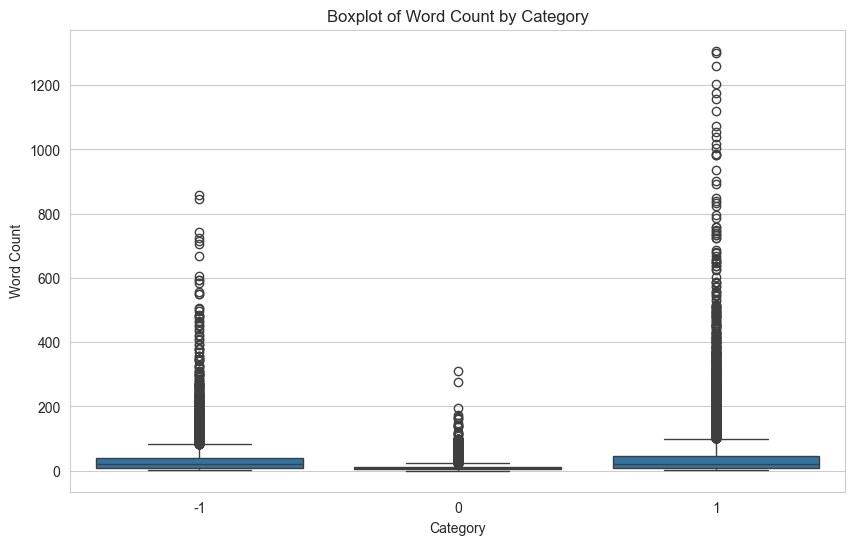

In [84]:
# Create a boxplot for the 'word_count' column categorized by 'category'
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='category', y='word_count')
plt.title('Boxplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

**Positive comments (category 1)**: The median word count is relatively high, and there are several outliers with longer comments, indicating that positive comments tend to be more verbose.

**Neutral comments (category 0)**: The median word count is the lowest, with a tighter interquartile range (IQR), suggesting that neutral comments are generally shorter.

**Negative comments (category -1)**: The word count distribution is similar to positive comments but with a slightly lower median and fewer extreme outliers.

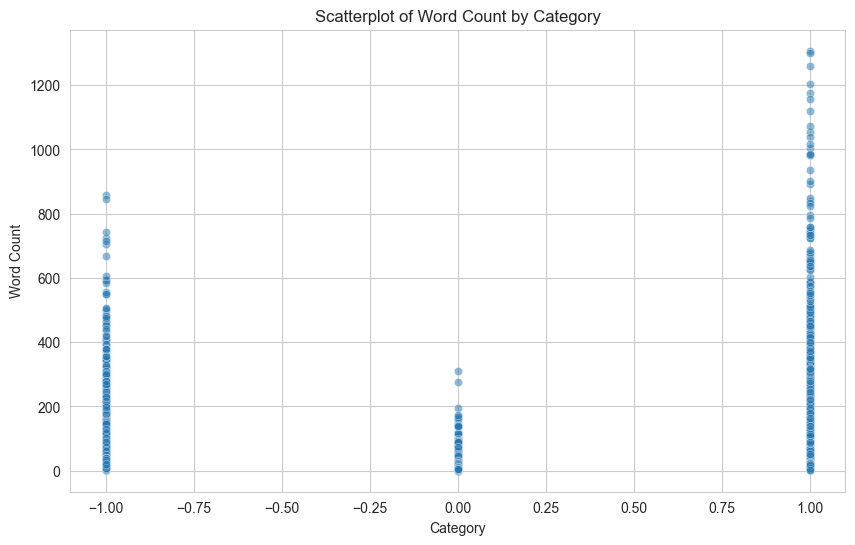

In [85]:
# Create a scatterplot between 'category' and 'wordcount'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='category', y='word_count', alpha=0.5)
plt.title('Scatterplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

<Axes: xlabel='category', ylabel='word_count'>

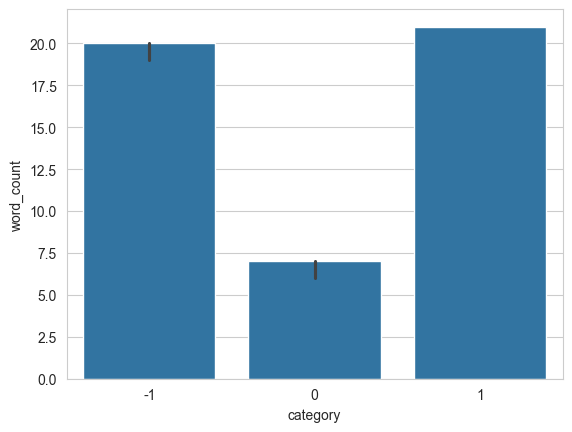

In [86]:
# median word counts among sentiments
sns.barplot(df,x='category',y='word_count',estimator='median')
     

### 4. Phase III: Advanced Linguistic Analysis (NLTK)
*Goal: Move beyond counts to semantic understanding. Using Natural Language Processing to identify the specific words driving sentiment.*

#### 4.1 NLTK Setup & Preprocessing
We employ the NLTK (Natural Language Toolkit) library to tokenize text and remove "stop words" (common words like "the", "is", "and" that add noise but little sentiment value).

In [87]:
# pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')

# Define Stopwords (English)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Tokenizes text and removes stopwords."""
    tokens = word_tokenize(text)
    # Filter for alphabetic words only and remove stopwords
    return [word for word in tokens if word.isalpha() and word not in stop_words]

# Apply to a sample or full dataset for analysis
# (Note: For large datasets, apply this step carefully to avoid memory issues)
df['tokens'] = df['clean_comment'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_comment,category,word_count,tokens
0,family mormon have never tried explain them th...,1,39,"[family, mormon, never, tried, explain, still,..."
1,buddhism has very much lot compatible with chr...,1,196,"[buddhism, much, lot, compatible, christianity..."
2,seriously don say thing first all they won get...,-1,86,"[seriously, say, thing, first, get, complex, e..."
3,what you have learned yours and only yours wha...,0,29,"[learned, want, teach, different, focus, goal,..."
4,for your own benefit you may want read living ...,1,112,"[benefit, may, want, read, living, buddha, liv..."


#### 4.2 Top Frequent Words by Sentiment (Stacked Analysis)
**Insight:** Instead of simple word counts, we analyze how the most frequent words are distributed across sentiments. This helps us distinguish between generic common words and sentiment-drivers.

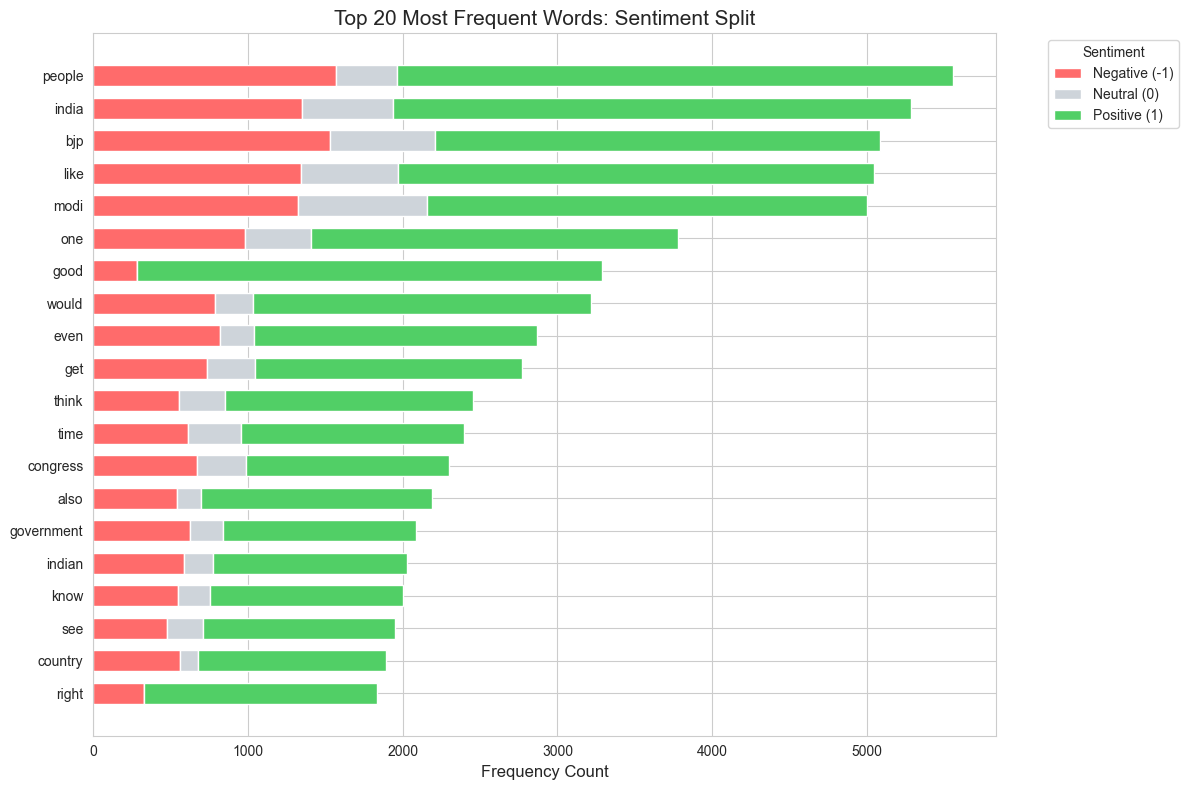

In [88]:
from collections import defaultdict


def plot_top_n_words_by_category_stacked(df, n=20):
    """
    Plots the top N most frequent words, stacking their sentiment distribution.
    Uses NLTK stopwords to ensure only meaningful words are plotted.
    """
    # Initialize a nested dictionary: word -> category -> count
    word_category_counts = defaultdict(lambda: {-1: 0, 0: 0, 1: 0})
    
    # Iteration with stopword filtering
    for comment, category in zip(df['clean_comment'], df['category']):
        words = [w for w in str(comment).split() if w.lower() not in stop_words and w.isalpha()]
        
        for word in words:
            # Ensure we only track valid categories
            cat_key = int(category) 
            if cat_key in [-1, 0, 1]:
                word_category_counts[word][cat_key] += 1

    # Calculate total frequency for sorting
    total_counts = {word: sum(counts.values()) for word, counts in word_category_counts.items()}
    
    # Get top N words
    top_words = sorted(total_counts, key=total_counts.get, reverse=True)[:n]
    
    # Prepare plotting arrays
    neg_counts = [word_category_counts[w][-1] for w in top_words]
    neu_counts = [word_category_counts[w][0] for w in top_words]
    pos_counts = [word_category_counts[w][1] for w in top_words]
    
    # Plotting
    plt.figure(figsize=(12, 8))
    bar_width = 0.65
    
    # Stacked Bars
    p1 = plt.barh(top_words, neg_counts, color='#FF6B6B', label='Negative (-1)', height=bar_width)
    p2 = plt.barh(top_words, neu_counts, left=neg_counts, color='#CED4DA', label='Neutral (0)', height=bar_width)
    
    # For the third bar, left = neg + neu
    left_pos = [i+j for i,j in zip(neg_counts, neu_counts)]
    p3 = plt.barh(top_words, pos_counts, left=left_pos, color='#51CF66', label='Positive (1)', height=bar_width)
    
    plt.title(f'Top {n} Most Frequent Words: Sentiment Split', fontsize=15)
    plt.xlabel('Frequency Count', fontsize=12)
    plt.gca().invert_yaxis() # Put most frequent at top
    plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Execute Visualization
plot_top_n_words_by_category_stacked(df)

#### 4.3 N-Gram Analysis (Bigrams)
**Why this matters:** Single words can be misleading. "Good" is positive, but "Not good" is negative. Bigrams (pairs of words) capture this context.

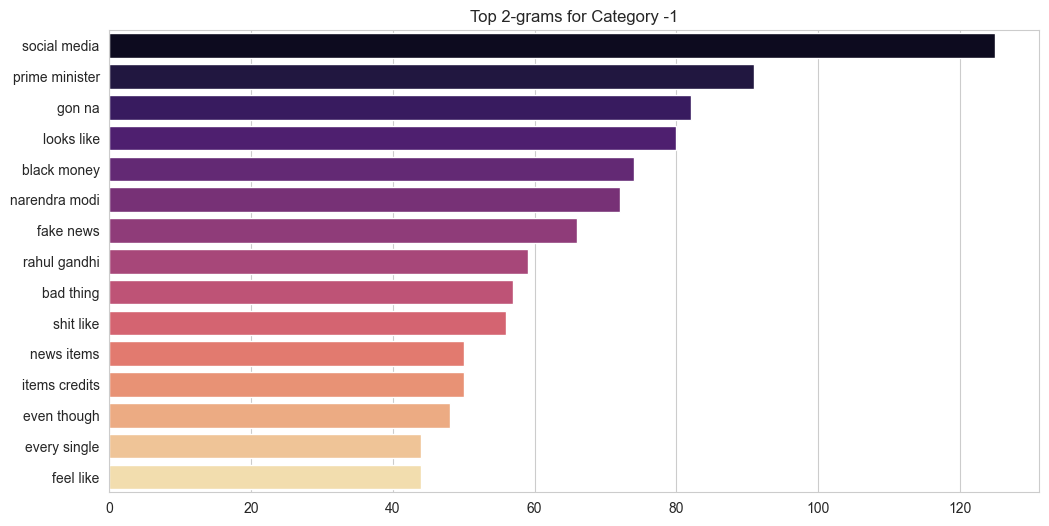

In [89]:
from nltk.util import ngrams

# Pre-tokenization for N-gram analysis
df['tokens'] = df['clean_comment'].apply(lambda x: [word for word in word_tokenize(str(x)) if word.isalpha() and word not in stop_words])

def plot_ngrams(category_code, n=2):
    """Generates and plots top N-grams for a category."""
    all_tokens = [word for tokens in df[df['category'] == category_code]['tokens'] for word in tokens]
    n_grams = ngrams(all_tokens, n)
    common_ngrams = Counter(n_grams).most_common(15)
    
    ngram_labels, counts = zip(*common_ngrams)
    ngram_labels = [' '.join(label) for label in ngram_labels]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=ngram_labels, palette='magma')
    plt.title(f'Top {n}-grams for Category {category_code}')
    plt.show()

# Visualize Bigrams for Negative Sentiment 
# (Looking for phrases like "waste time", "bad policy")
plot_ngrams(-1, n=2)

#### 4.4 Word Clouds
A qualitative visual representation of the vocabulary.

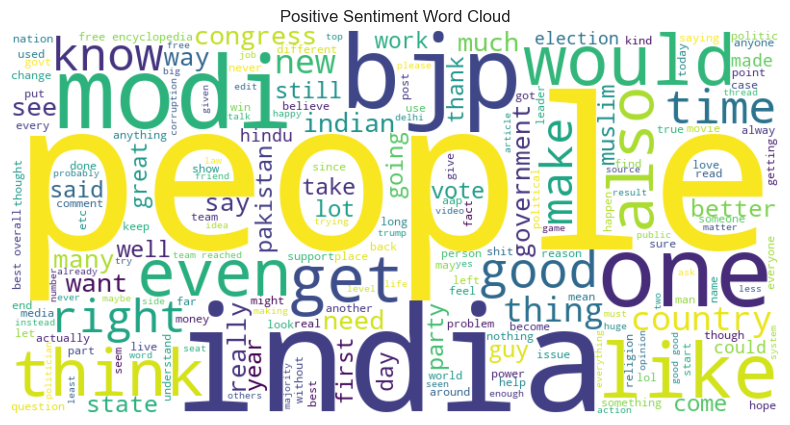

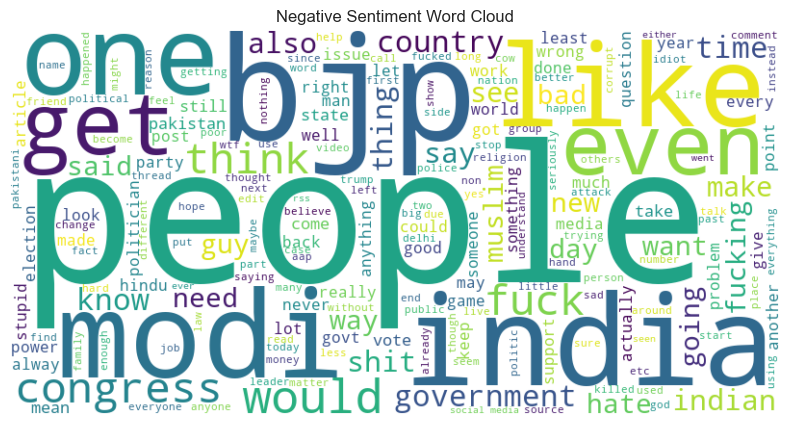

In [90]:
# pip install wordcloud
from wordcloud import WordCloud

def generate_wordcloud(category_code, title):
    text = ' '.join(df[df['category'] == category_code]['clean_comment'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white', 
                          stopwords=stop_words, min_font_size=10).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate clouds for all categories
generate_wordcloud(1, "Positive Sentiment Word Cloud")
generate_wordcloud(-1, "Negative Sentiment Word Cloud")

### 5. Conclusion & Next Steps
This EDA confirms that the dataset is robust and ready for modeling, provided specific preprocessing steps are maintained.

**Key Findings:**

1. **Data Quality:** The cleaning pipeline successfully removed duplicates and noise (URLs), reducing the dataset size marginally (<2% data loss) but significantly improving quality.

2. **Imbalance:** The 2:1 ratio between Positive and Negative classes may require techniques like SMOTE or Class Weights during the modeling phase to ensure the model captures negative signals effectively.

3. **Linguistic Features:** N-gram analysis suggests that context (word pairs) is critical. A "Bag of Words" approach might be insufficient; TF-IDF or Word Embeddings (Word2Vec/BERT) are recommended for the feature extraction phase.

**Upcoming Phase:**

* Best Model Selection and Optimization

* Hyperparameter Tuning

* Deployment Strategy using Flask/Streamlit.